In [9]:

!pip3 install numpy
!pip3 install opencv-python
!pip3 install opencv-contrib-python


import cv2
print(cv2.__version__)
import numpy as np
import pandas as pd

# unzip files
"""!unzip left.zip
!unzip right.zip"""

# basic test to see the image
left_path = 'left/left-020.png'
right_path = 'right/right-000.png'
left = cv2.imread (left_path)
right = cv2.imread (right_path)
# y, x, c
# ((480, 640, 3), (480, 640, 3))
left.shape, right.shape

4.1.2


((480, 640, 3), (480, 640, 3))

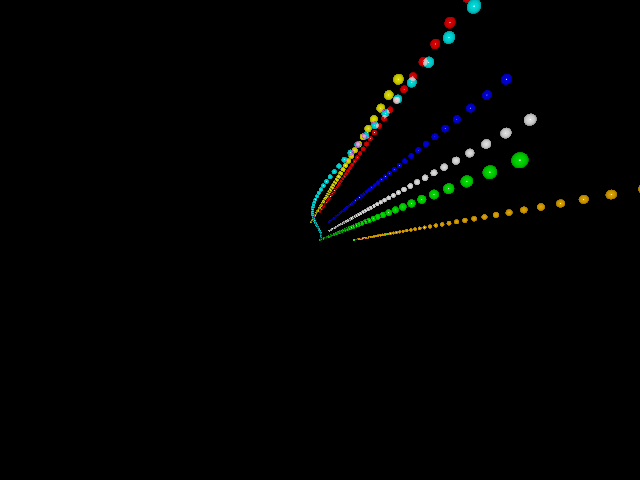

In [10]:
# every time, given a number (0-49), 
# read that frame left & right image
# read them as n-array
def readFrame(i):
  left_path = 'left/left-0'
  right_path = 'right/right-0'
  if i<10:
    left_path = left_path + '0' + str(i) + '.png'
    right_path = right_path + '0' + str(i) + '.png'
  else:
    left_path = left_path + str(i) + '.png'
    right_path = right_path + str(i) + '.png'
  #print( left_path, right_path )
  return cv2.imread(left_path), cv2.imread(right_path)

# add two images
def addImg(im1, im2):
  return np.add(im1, im2)

synLeft, synRight = readFrame(0)
for i in range(1, 50):
  left, right = readFrame(i)
  synLeft = addImg(synLeft, left)
  synRight = addImg(synRight, right)
# cv2.imshow cannot run on colab
from google.colab.patches import cv2_imshow
cv2_imshow( synLeft )
print()

In [11]:
# the background is black, for RGB, it is (0, 0, 0) 
# so, use a very simple way to remove the background
# such as: get every pixel RGB value,
# if r+g+b < 100, that is the background pixels, skip it
# because the objects are of 7 colors:
"""
  red:	r>100, g, b almost 0
  yellow:	r, g almost the same, b almost zero
  blue:	b>100, r, g almost 0
  white:	r, g, b, all > 100, almost the same
  cyan:	g, b almost the same, r almost zero
  green:	g>100, r, b almost 0
  gold:	r>100, g less than r, b almost 0
"""
# if the pixel's RGB value is among the above, 
# it will be the candidate pixel of object
# remove background pixels
# return the positions of all candidate pixels
def removeBG(im): 
  ny, nx, nc = im.shape
  pos = []
  for i in range(ny):
    for j in range(nx):
      g = im[i, j, 0]
      b = im[i, j, 1]
      r = im[i, j, 2]
      s = int(r) + int(g) + int(b)
      if s<1:
        pass
      elif s<100 or s>750:
        #print([i, j, r, g, b, s])
        pass
      else:
        tmp = [i, j]
        pos.append(tmp)
  pos = np.array(sorted(pos, key=lambda x: x[0]))
  #print(pos.shape)
  return pos

def almostZero(v):
  if v<65:
    return True
  return False

def almostSame(v1, v2):
  if abs(v1-v2)<10:
    return True
  return False


# !pip install -U scikit-learn 
from sklearn.cluster import KMeans

# according to the positions of candidate pixels
# use K-means to cluster them, 
# then choose the centroid as the position of each object
# the returned is: y, x, r, g, b for every cluster's centroid pixel
def getClusters(im, nc=7):
  X = removeBG(im)
  kmeans = KMeans(n_clusters=nc, random_state=0).fit(X)
  cluster = avgColor(im, X, kmeans.labels_)
  dic = {}
  for i in cluster:
    lab = identify(i)
    #print('------', i, ', ', lab)
    dic[lab] = i
  return dic

# after using the K-means to cluster those candidate pixels
# for every cluster that is considered as an object
# averaging all the RGB value of all the pixels in the cluster
# because, for every cluster, there are some noise RGB values
# for example, the green object, its center maybe shining spot whose RGB is (255, 255, 255)
# by averaging, such problem can be avoided
def avgColor(im, X, labels):
  dic = {}
  for i in range( len(labels) ):
    v = labels[i]
    if v not in dic:
      dic[v] = [i]
    else:
      dic[v].append(i)
  update = []
  for i in dic:
    cds = dic[i]
    cl = len(cds)
    py = 0
    px = 0
    bt, gt, rt = 0.0, 0.0, 0.0
    for c in cds:
      y = X[c, 0]
      x = X[c, 1]
      b = im[y, x, 0]
      g = im[y, x, 1]
      r = im[y, x, 2]
      py = py + y
      px = px + x
      bt = bt + b
      gt = gt + g
      rt = rt + r
    update.append( [py/cl, px/cl, rt/cl, gt/cl, bt/cl] )
  update = np.array(update)
  #print( np.rint( update ) )
  return np.rint( update )

# identify the centroid pixel of every object
# label them as different colors
def identify(obj):
  r = obj[2]
  g = obj[3]
  b = obj[4]
  if r>100 and almostZero(g) and almostZero(b):
    return 'red'
  if almostSame(r, g) and almostZero(b):
    return 'yellow'
  if b>100 and almostZero(r) and almostZero(g):
    return 'blue'
  if almostSame(r, g) and almostSame(r, b):
    return 'white'
  if almostSame(g, b) and almostZero(r):
    return 'cyan'
  if g>100 and almostZero(r) and almostZero(b):
    return 'green'
  if r>100 and g>50 and almostZero(b):
    return 'gold'
  return 'green'


import math
# according to focal length and baseline 
# to calculate the distance for each object
def calDis(left_cluster, right_cluster):
  # focal lengths of 12 m
  # baseline 3.5 km
  f = 12.0
  B = 3.5*1000
  half_img_x = 640/2
  micron = math.pow(10, -6)

  dis = {}
  objects = ['red', 'yellow', 'blue', 'white', 'cyan', 'green', 'gold']
  for label in objects:
    dis[label] = -1

  for label in left_cluster:
    if label not in right_cluster:
      pass
    #
    xL = left_cluster[label][1] - half_img_x
    xR = right_cluster[label][1] - half_img_x
    Z = f*B/( (xL - xR)*micron*10 )
    dis[label] = Z
  return dis

from decimal import Decimal
# print out for testing 
def printDic(dic, frame=1, flag=False):    
  for i in dic:
    if flag:
      print(frame, end='\t')
    if flag and dic[i] == -1:
      print(i, '\t', 'not visible')
    else: 
      num = dic[i]
      try:
        print(i, '\t', "{:.2E}".format(Decimal( num )) )
      except BaseException:
        print(i, '\t', dic[i] )
  return 

cols = ['frame', 'red_x', 'red_y', 'yellow_x', 'yellow_y', 'blue_x', 'blue_y', 'white_x', 'white_y', 'cyan_x', 'cyan_y', 'green_x', 'green_y', 'gold_x', 'gold_y']
left_df = pd.DataFrame(columns = cols)
right_df = pd.DataFrame(columns = cols)

def recordPos(cluster, df, i):
  dic = {}
  dic['frame'] = i
  for label in cluster:
    info = cluster[label]
    xl = label + '_x'
    yl = label + '_y'
    x = info[1]
    y = info[0]
    dic[xl] = x
    dic[yl] = y
  df = df.append(dic, ignore_index=True)
  return df



frame 	 identity 	 distance
0	red 	 1.24E+8
0	yellow 	 1.31E+8
0	blue 	 1.35E+8
0	white 	 1.27E+8
0	cyan 	 not visible
0	green 	 1.24E+8
0	gold 	 1.24E+8
1	red 	 1.24E+8
1	yellow 	 1.31E+8
1	blue 	 1.31E+8
1	white 	 1.24E+8
1	cyan 	 not visible
1	green 	 1.24E+8
1	gold 	 1.24E+8
2	red 	 1.24E+8
2	yellow 	 1.27E+8
2	blue 	 1.27E+8
2	white 	 1.24E+8
2	cyan 	 not visible
2	green 	 1.24E+8
2	gold 	 1.17E+8
3	red 	 1.20E+8
3	yellow 	 1.27E+8
3	blue 	 1.27E+8
3	white 	 1.24E+8
3	cyan 	 not visible
3	green 	 1.17E+8
3	gold 	 1.17E+8
4	red 	 1.17E+8
4	yellow 	 1.24E+8
4	blue 	 1.24E+8
4	white 	 1.20E+8
4	cyan 	 1.14E+8
4	green 	 1.17E+8
4	gold 	 1.17E+8
5	red 	 1.17E+8
5	yellow 	 1.24E+8
5	blue 	 1.20E+8
5	white 	 1.17E+8
5	cyan 	 1.14E+8
5	green 	 1.17E+8
5	gold 	 1.11E+8
6	red 	 1.17E+8
6	yellow 	 1.20E+8
6	blue 	 1.17E+8
6	white 	 1.17E+8
6	cyan 	 1.11E+8
6	green 	 1.11E+8
6	gold 	 1.14E+8
7	red 	 1.11E+8
7	yellow 	 1.17E+8
7	blue 	 1.17E+8
7	white 	 1.11E+8
7	cyan 	 1.08E+8
7	green 	 1.11E

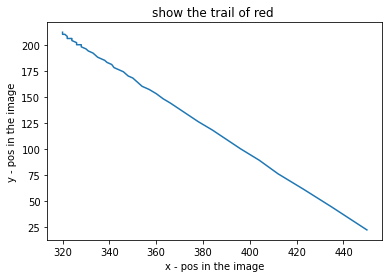

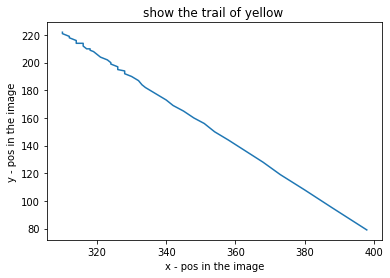

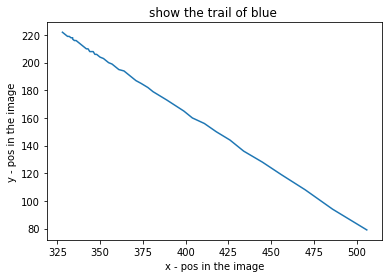

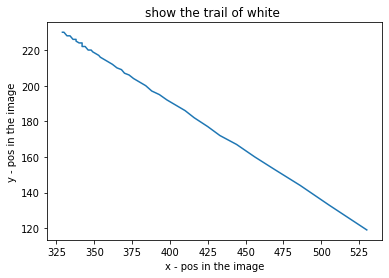

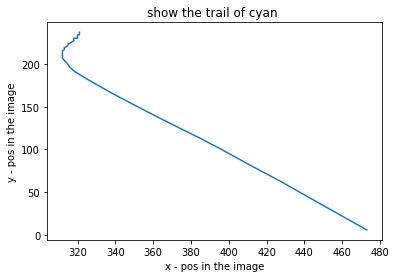

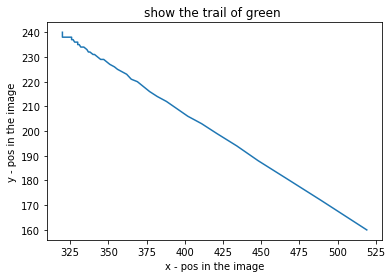

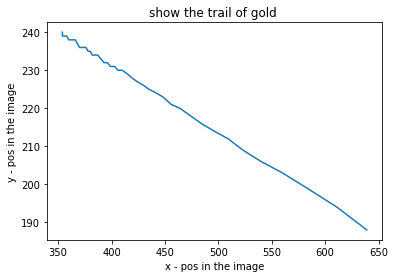

UFO:	 cyan 


In [12]:

def getTrails(df, label):
  xl = label + '_x'
  yl = label + '_y'
  x_axis = df[xl]
  y_axis = df[yl]
  tmp_x = []
  tmp_y = []
  for i in range( len(x_axis) ):
    x = x_axis[i]
    y = y_axis[i]
    if np.isnan(x) or np.isnan(y):
      #print(x, y)
      pass
    else:
      tmp_x.append(x)
      tmp_y.append(y)
  return np.array(tmp_x), np.array(tmp_y)

import matplotlib.pyplot as plt 
def drawTrail(x1, y1, lal='red'):
  plt.plot(x1, y1, label = "left")
  plt.xlabel('x - pos in the image') 
  plt.ylabel('y - pos in the image') 
  plt.title('show the trail of ' + lal + ' ') 
  plt.show() 
  return 

# calculate a straight line to test
def formStraightLine(x_axis, y_axis):
  nx = np.array(x_axis)
  ny = np.array(y_axis)
  #
  mx = nx.mean()
  my = ny.mean()
  #
  size = len(x_axis)
  size = size//3 * 2
  mx1 = nx[:size].mean()
  my1 = ny[:size].mean()
  #
  # y = ax + b
  # (mx, my), (mx1, my1)
  a = (my1 - my) / (mx1 - mx)
  b = my - a*mx
  #print(mx, my, mx1, my1, a, b)
  return a, b

def accumulate(x_axis, y_axis):
  a, b = formStraightLine(x_axis, y_axis)
  size = len(x_axis)
  #print('there are ' + str(size) + ' points')
  count = 0
  for i in range(size):
    #print(i, size, '----------')
    x = x_axis[i]
    y = y_axis[i]
    y_pred = a * x + b
    error = abs(y_pred - y)
    #print(error)
    off_set = 3
    if error < off_set:
      count = count + 1
  return count


# because in the first 0-3 frames
  # cyan & green objects are overlapped 
# on 46 frame, gold object in on the border of left image
# for the last 3 frames 47-49, 
  # at least one object are not visible, namely, out of the image
print('frame', '\t', 'identity', '\t', 'distance')
for i in range(0, 50):
  #print('----------------', i, '----------------')
  left, right = readFrame(i)
  nll = 7
  nlr = 7
  if i<4:
    nll = 6
    nlr = 6
  if i==47:
    nll = 6
  if i==48:
    nll = 5
  if i==49:
    nll = 4
    nlr = 5
  left_cluster = getClusters(left, nll)
  right_cluster = getClusters(right, nlr)
  """printDic(left_cluster)
  print('============')
  printDic(right_cluster)"""
  dis = calDis(left_cluster, right_cluster)
  printDic(dis, i, True)
  left_df = recordPos(left_cluster, left_df, i)
  right_df = recordPos(right_cluster, right_df, i)
  #print()

# because some row may include NaN, remove those rows and reset index
# left_df = left_df.dropna().reset_index()
# right_df = right_df.dropna().reset_index()

# find the UFO by fitting the trails with straight lines
detect = {}
objects = ['red', 'yellow', 'blue', 'white', 'cyan', 'green', 'gold']
for label in objects[:]:
  x_axis, y_axis = getTrails(left_df, label)
  #print(x_axis, y_axis)
  drawTrail(x_axis, y_axis, label) # for visualization & testing
  count = accumulate(x_axis, y_axis)
  #print(count, ' points are approximately on a straight line')
  if count < 50*0.6:
    detect[label] = 0
  else:
    detect[label] = 1
  #print()

def findUFO(detect):
  name = ''
  for i in detect:
    if detect[i] == 0:
      name = name + i + ' '
  return name


print('UFO:\t', findUFO(detect) )